In [1]:
import os
import math
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import accuracy_score, recall_score,balanced_accuracy_score
from fairlearn.metrics import MetricFrame, false_positive_rate, selection_rate, false_negative_rate, count

In [2]:
pred_folder = "/Users/han/Documents/GitHub/GLOBEM/tmp/cross_validate"
faireval_folder = "fairevals"
config_names = ['ml_xu_personalized','ml_wang','ml_xu_interpretable','ml_chikersal']
eval_task = 'single'
pred_target = 'dep_endterm'
ds_keys = ['INS-W_1', 'INS-W_2', 'INS-W_3', 'INS-W_4']
sensitive_attrs = ["race", "gender", "student_1stGen", "student_international", 
                    "generation", "orientation_heterosexual", "parent_edu_father", "parent_edu_mother"]

sensitive_attrs_mapping = {
    "race": "Race",
    "gender": "Gender",
    "student_1stGen": "First Generation Student",
    "student_international": "International Student",
    "college_engineer": "Engineering Major",
    "generation": "Generation Status",
    "orientation_heterosexual": "Heterosexual Orientation",
    "parent_edu_father": "Father's Education Level",
    "parent_edu_mother": "Mother's Education Level"
}

metrics = ["accuracy", "recall", "fpr", "fnr"]
metrics_fullname = ["Accuracy", "Recall", "False positive rate", "False negative rate"]

value2label = {
#     "race": {0: "Asian", 1: "Black", 2: "White", 3: "Latinx", 4: "Biracial"}, TODO: Leijie to double check
    "race": {0: "Asian", 1: "White", 2: "Biracial", 3: "Black", 4: "Latinx"},
    "gender": {1: "Male", 2: "Non-male", 3: "Non-male", 4: "Non-male", 6: "Non-male"},
    "orientation_heterosexual": {0: "Non-heterosexual", 1: "Heterosexual"},
    "student_international": {0: "Non-international", 1: "International"},
    "student_1stGen": {0: "Non-first-gen", 1: "First-gen"},
    "parent_edu_mother": {0: "Below bachelor's degree", 1: "Bachelor's degree and above"},
    "parent_edu_father": {0: "Below bachelor's degree", 1: "Bachelor's degree and above"},
    "generation": {0: "Non-immigrant", 1: "Immigrant"},
    "disability": {0: "Non-disabled", 1: "Disabled"}
}

In [3]:
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
def generate_fairevals(config_name, eval_task, pred_target, ds_key, cnt = 10): # cnt = 40 when pred_target = 'dep_weekly' 
    
    folder = os.path.join(pred_folder, config_name, eval_task, pred_target, ds_key)
    
    if config_name == 'ml_chikersal':
        cnt = 10
    
    preds = []
    targs = []
    demos = []
    for k in range(cnt):
        path_pred = os.path.join(folder, 'y_pred_{:03d}.npy'.format(k + 1))
        path_targ = os.path.join(folder, 'y_targ_{:03d}.csv'.format(k + 1))
        path_demo = os.path.join(folder, 'demographic_test_{:03d}.csv'.format(k + 1))

        pred = np.load(path_pred, allow_pickle=True)
        targ = pd.read_csv(path_targ)["y_raw"]
        demo = pd.read_csv(path_demo).iloc[:, 1:]

        preds.append(pred)
        targs.append(targ)
        demos.append(demo)

    pred = np.concatenate(preds)
    targ = pd.concat(targs)
    demo = pd.concat(demos)
    correct_pred = pred == targ
    correct_pred.replace({True: 1, False: 0},inplace=True)
    correct_pred = pd.concat([demo, correct_pred.rename('correct_pred')], axis=1)
    
    metrics = {"accuracy": accuracy_score, 
                "recall": recall_score, 
                "fnr": false_negative_rate, 
                "fpr": false_positive_rate
            }
    
    # calculating balanced accuracy
    balanced_acc = balanced_accuracy_score(pred, targ)
    
    fair_evals = {}
    for col in demo.columns:
        faireval = MetricFrame(metrics=metrics, y_true=targ, y_pred=pred, sensitive_features=demo[col])
        fair_evals[col] = faireval
    
    folder_output = os.path.join(faireval_folder, config_name, eval_task, pred_target, ds_key)
    mkdir(os.path.join(folder_output))
    for col, mf in fair_evals.items():
        mf.by_group.to_csv(os.path.join(folder_output, '{}_by_group.csv'.format(col)))
    mf.overall.append(pd.Series(balanced_acc, index=['bal_acc'])).to_csv(os.path.join(folder_output, 'overall.csv'.format(col)))
    correct_pred.to_csv(os.path.join(folder_output, 'correct_prediction.csv'),index=False)

In [5]:
for config_name in config_names:
    for ds_key in ds_keys:
        generate_fairevals(config_name, eval_task, pred_target, ds_key)

/Users/han/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/han/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/han/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/han/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/metrics/_classifica

In [6]:
def generate_plot_data(config_name, sens_attr, eval_task = 'single', pred_target = 'dep_weekly'):
    metrics = ["accuracy", "recall", "fpr", "fnr"]
    faireval_dict = {metric: {} for metric in metrics}
    for ds_index, ds_key in enumerate(ds_keys):
        folder_output = os.path.join(faireval_folder, config_name, eval_task, pred_target, ds_key)
        faireval = pd.read_csv(os.path.join(folder_output, '{}_DEMO_by_group.csv'.format(sens_attr)))
        faireval = faireval.rename(columns={f"{sens_attr}_DEMO": sens_attr}) # remove the suffix DEMO
        # remove unspecified values, such as 5, 6 in genders
        unspecified_labels = faireval[~faireval[sens_attr].isin(value2label[sens_attr])].index
        faireval.drop(unspecified_labels, inplace=True)
        # replace numbers with labels
        faireval[sens_attr] = faireval[sens_attr].replace(value2label[sens_attr])

        faireval = faireval.set_index(sens_attr)
        for metric in metrics:
            faireval_dict[metric][f"DS{ds_index + 1}"] = faireval[metric]
    
    # put datasets in the second level of indexing
    for metric in metrics:
        faireval_dict[metric] = pd.concat(faireval_dict[metric], axis=1)
    return faireval_dict

In [7]:
def plot_faireval(config_name, sens_attr, eval_task = 'single', pred_target = pred_target):
    
    faireval_dict = generate_plot_data(config_name, sens_attr, eval_task, pred_target)
    
    sns.set_theme(style="whitegrid", palette="Set2")
    plt.figure(figsize=(8, 6)) 
    plt.rcParams["font.family"] = "sans-serif"

    x_fig_num, y_fig_num = 2, 2
    for mindex, metric in enumerate(metrics):
        now_faireval = faireval_dict[metric]

        plt.subplot(x_fig_num, y_fig_num, mindex + 1)
        sens_labels_num = len(now_faireval.index)
        width = 1.25 / sens_labels_num
        X_axis = np.arange(2 * len(now_faireval.columns), step=2)
        for sens_index, sens_label in enumerate(now_faireval.index):
            plt.bar(x = X_axis + (sens_index - sens_labels_num/2 + 1/2) * width,
                    height = now_faireval.iloc[sens_index, :],
                    width=width, align="center", 
                    label=sens_label
                )
            
            plt.xticks(X_axis, now_faireval.columns.to_list(), fontsize=8)
            plt.yticks(np.arange(0, 1.2, 0.5))
            plt.ylim((0,1))
        
        plt.title(metrics_fullname[mindex], fontdict={"fontsize": 14, "fontweight": 10}, pad=10)

    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.legend(ncol=1, loc='lower left', bbox_to_anchor=(1.04, 0.8), title=sensitive_attrs_mapping[sens_attr], title_fontsize=11)
    mkdir(os.path.join("figures/fairness"))
    plt.savefig(f"figures/fairness/{config_name}-{eval_task}-{pred_target}-{sens_attr}.png", bbox_inches='tight',format='png')

/var/folders/s3/3zpmls310rq1lm71sn6k6w8m0000gn/T/ipykernel_29991/1633951401.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 6))


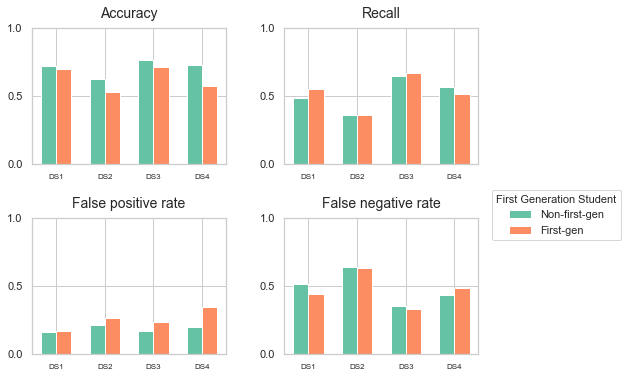

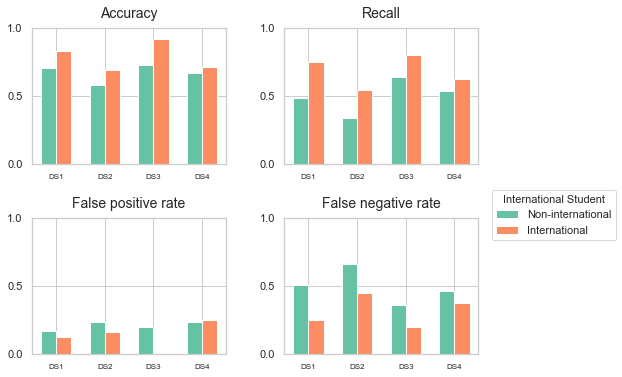

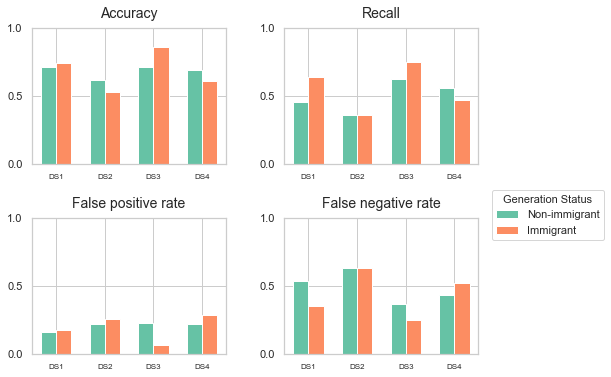

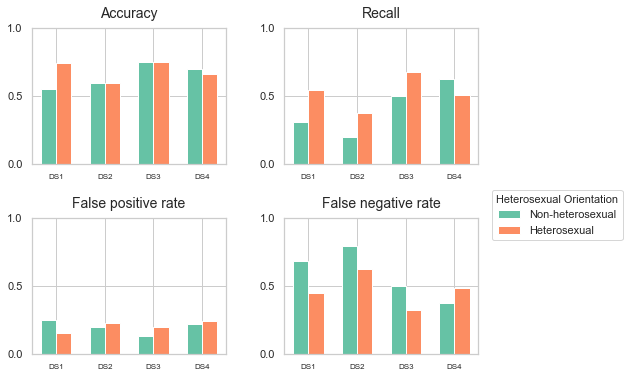

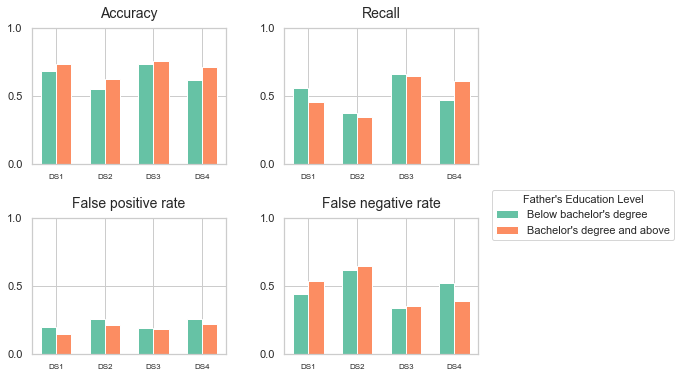

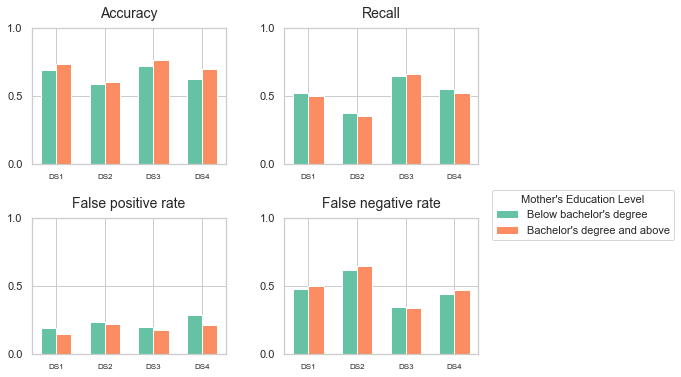

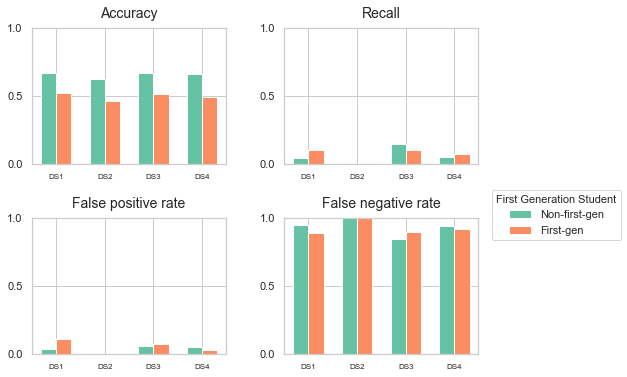

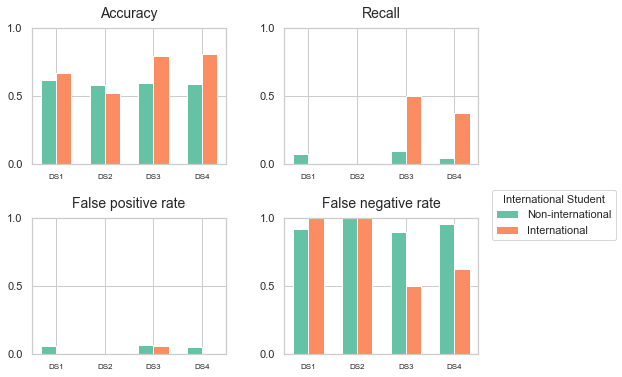

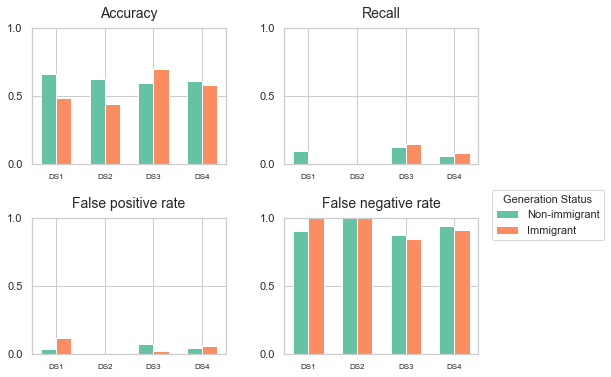

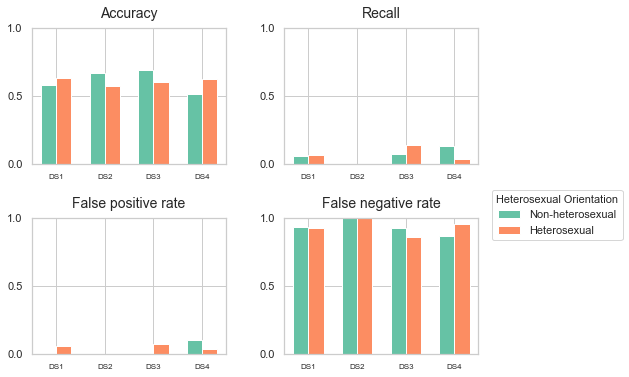

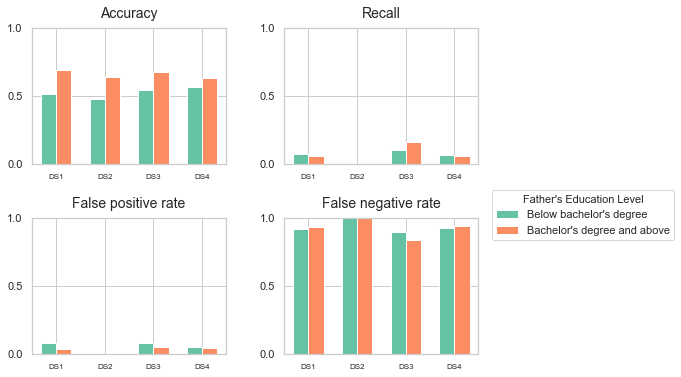

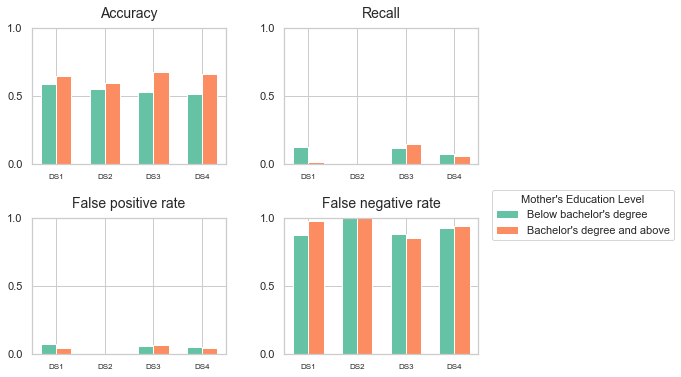

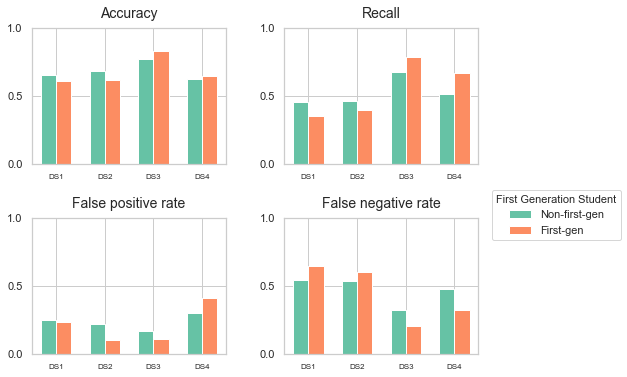

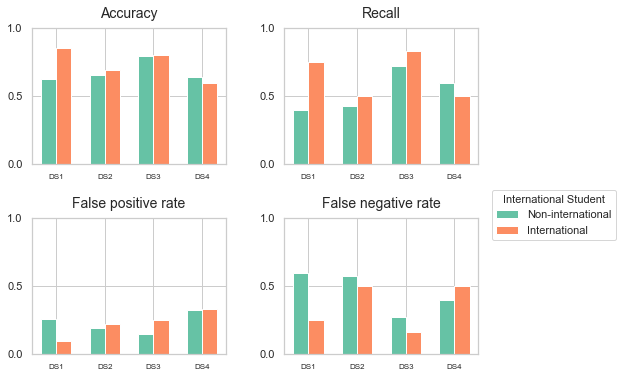

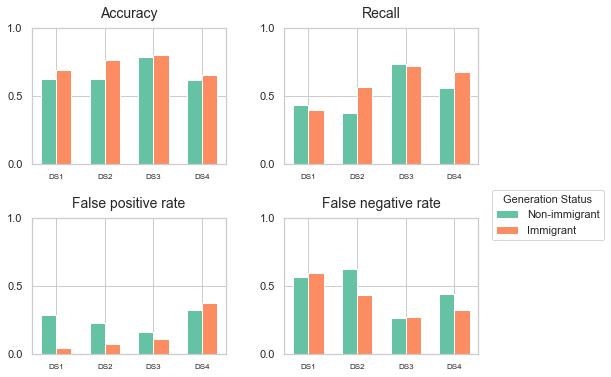

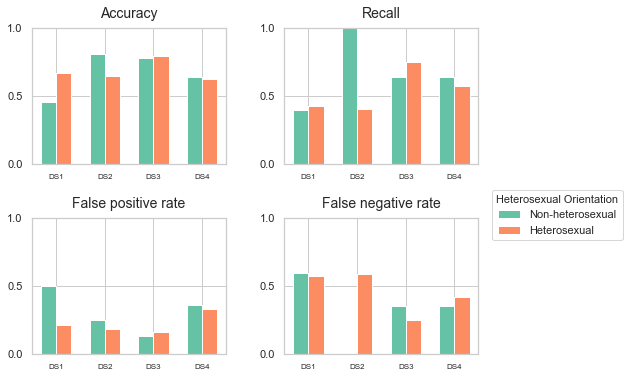

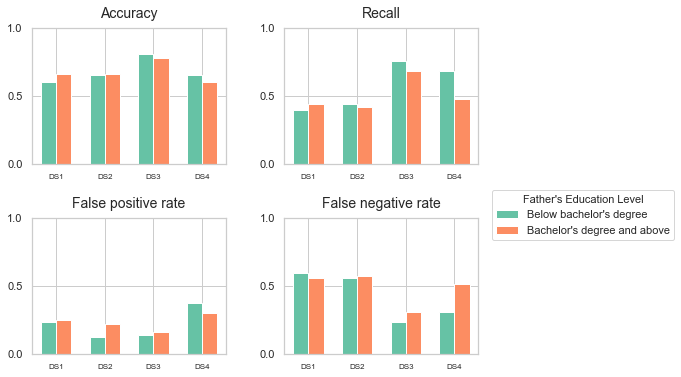

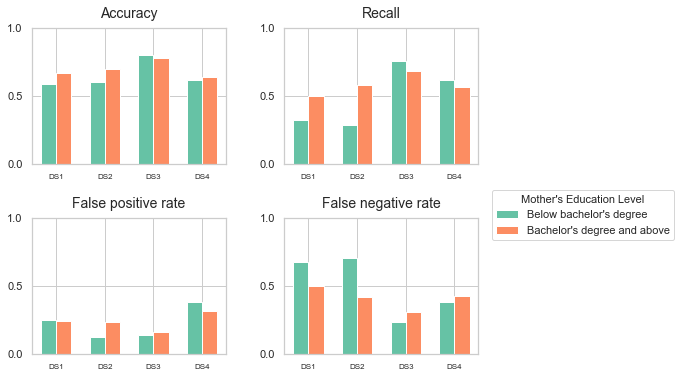

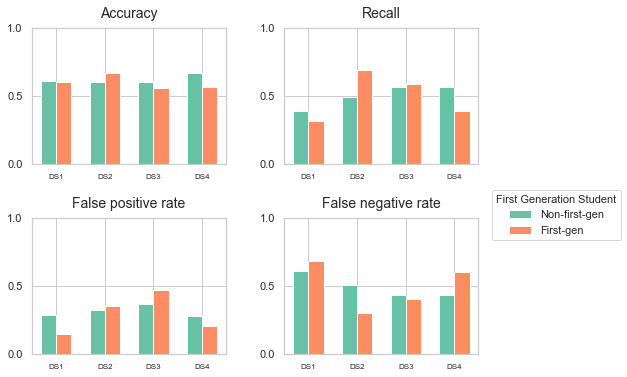

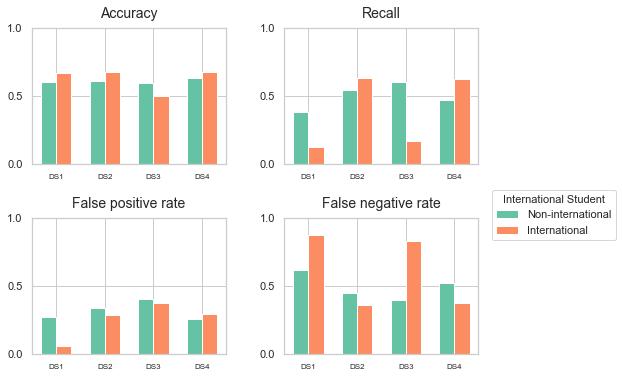

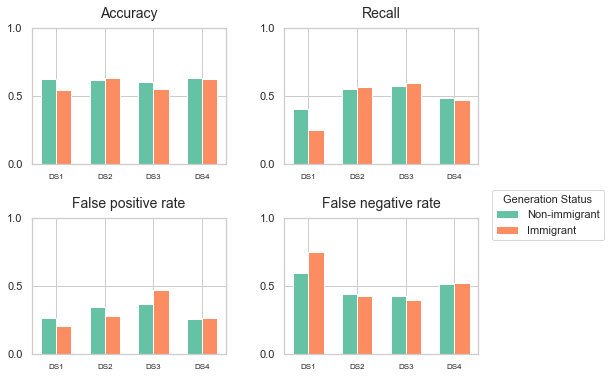

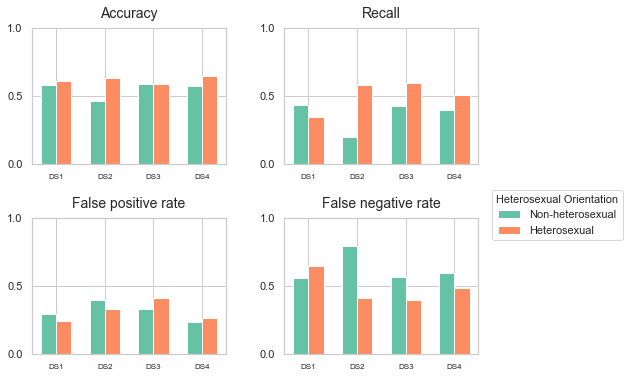

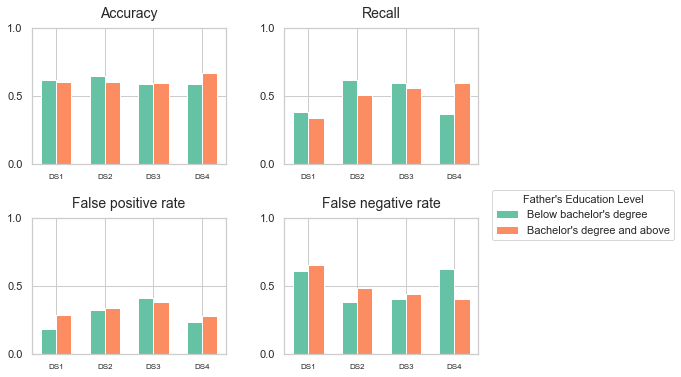

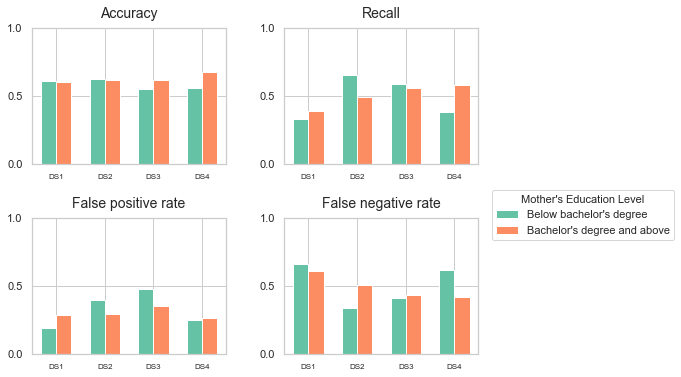

In [8]:
for config_name in config_names:
    for sens_attr in sensitive_attrs[2:]:
        plot_faireval(config_name, sens_attr)

### Statistical Analysis

- url: https://github.com/cdicicci/fairness-testing/blob/master/permTestExamples.py
- paper: Evaluating Fairness Using Permutation Tests (https://dl.acm.org/doi/pdf/10.1145/3394486.3403199)


In [9]:
def demo_preprocessing(data):
    
    data['gender_DEMO'] = data['gender_DEMO'] != 1
    data['gender_DEMO'].replace({True: 1, False: 0}, inplace=True)
    data['student_international_DEMO'] = data['student_international_DEMO'] != 0
    data['student_international_DEMO'].replace({True: 1, False: 0}, inplace=True)
    data['student_1stGen_DEMO'] = data['student_1stGen_DEMO'] != 0
    data['student_1stGen_DEMO'].replace({True: 1, False: 0}, inplace=True)
    data['gender_DEMO'].replace({1:'non-male',0:'male'},inplace=True)
    data['orientation_heterosexual_DEMO'].replace({1:'heterosexual',0:'non-heterosexual'},inplace=True)
    data['student_international_DEMO'].replace({1:'international',0:'non-international'},inplace=True)
    data['student_1stGen_DEMO'].replace({1:'first-gen',0:'non-first-gen'},inplace=True)
    data['parent_edu_mother_DEMO'].replace({1:'bachelor and above',0:'below bachelor'},inplace=True)
    data['parent_edu_father_DEMO'].replace({1:'bachelor and above',0:'below bachelor'},inplace=True)
    data['generation_DEMO'].replace({1:'immigrant',0:'non-immigrant'},inplace=True)
    data['race_asian_DEMO'] = (df['race_DEMO'] == 0).replace({True:'asian',False:'non-asian'})
    data['race_black_DEMO'] = (df['race_DEMO'] == 3).replace({True:'black',False:'non-black'})
    data['race_white_DEMO'] = (df['race_DEMO'] == 1).replace({True:'white',False:'non-white'})
    data['race_latinx_DEMO'] = (df['race_DEMO'] == 4).replace({True:'latinx',False:'non-latinx'})
    data['race_biracial_DEMO'] = (df['race_DEMO'] == 2).replace({True:'biracial',False:'non-biracial'})
    if ds_key.split('_')[-1] == '1':
        data['college_engineer_DEMO'].replace({1:'engineering',0:'non-engineering'},inplace=True)
    else:
        data['disability_DEMO'].replace({1:'disabled',0:'non-disabled'},inplace=True)
    
    data.rename(columns = {col: '_'.join(col.split('_')[:-1]) for col in data.columns}, inplace=True)
    if ds_key.split('_')[-1] == '1':
        data = data.rename(columns={'orientation_heterosexual':'orientation','student_international':'international student',
                                     'student_1stGen': 'first-gen student','parent_edu_mother':"mom's edu",'parent_edu_father':"dad's edu",
                                    'race_asian_DEMO': 'asian', 'race_black_DEMO': 'black', 'race_white_DEMO': 'white', 'race_latinx_DEMO': 'latinx', 'race_biracial_DEMO': 'biracial',
                                   'college_engineer':'college'})
        data.drop(columns='college',inplace=True) # comment out if the analysis of college is needed
    else:
        data = data.rename(columns={'orientation_heterosexual':'orientation','student_international':'international student',
                                    'race_asian_DEMO': 'asian', 'race_black_DEMO': 'black', 'race_white_DEMO': 'white', 'race_latinx_DEMO': 'latinx', 'race_biracial_DEMO': 'biracial',
                                     'student_1stGen': 'first-gen student','parent_edu_mother':"mom's edu",'parent_edu_father':"dad's edu"})
        data.drop(columns='disability',inplace=True) # comment out if the analysis of disability is needed
    
    return data

In [10]:
def basic_stats(df):
    
    col2remove = ['correct','international student','race','race_black','race_latinx']
    demo_cols = df.drop(columns=col2remove).columns.tolist()
    stats_results = {}
    results = pd.DataFrame()
    for demo_col in demo_cols:
        stats_results[demo_col] = {}
        stats_results[demo_col]['stats'] = []
        stats_results[demo_col]['p'] = []
        group_labels = df[demo_col].tolist()   
        if demo_col == 'race':
            group_a = df[demo_col].unique()[0]
            group_b = df[demo_col].unique()[1]
            group_c = df[demo_col].unique()[2]
            group_d = df[demo_col].unique()[3]
#             group_e = df[demo_col].unique()[4]
            group_A = df[df[demo_col] == group_a]['correct']
            group_B = df[df[demo_col] == group_b]['correct']
            group_C = df[df[demo_col] == group_c]['correct']
            group_D = df[df[demo_col] == group_d]['correct']
#             group_E = df[df[demo_col] == group_e]['correct']
            H,p = stats.kruskal(group_A, group_B, group_C, group_D)
            print(f'{group_a}:{group_A.shape[0]}, {round(group_A.shape[0]/len(group_labels)*100,2)}%; {group_b}:{group_B.shape[0]},{round(group_B.shape[0]/len(group_labels)*100,2)}%; {group_c}:{group_C.shape[0]}, {round(group_C.shape[0]/len(group_labels)*100,2)}%; {group_d}:{group_D.shape[0]}, {round(group_D.shape[0]/len(group_labels)*100,2)}%')       
#             print(f'{group_a}:{group_A.shape[0]}, {round(group_A.shape[0]/len(group_labels)*100,2)}%; {group_b}:{group_B.shape[0]},{round(group_B.shape[0]/len(group_labels)*100,2)}%; {group_c}:{group_C.shape[0]}, {round(group_C.shape[0]/len(group_labels)*100,2)}%; {group_d}:{group_D.shape[0]}, {round(group_D.shape[0]/len(group_labels)*100,2)}%; {group_e}:{group_E.shape[0]}, {round(group_E.shape[0]/len(group_labels)*100,2)}%')       
        else:
            group_a = df[demo_col].unique()[0]
            group_b = df[demo_col].unique()[1]
            group_A = df[df[demo_col] == group_a]['correct']
            group_B = df[df[demo_col] == group_b]['correct']
            print(f'{group_a}:{group_A.shape[0]}, {round(group_A.shape[0]/len(group_labels)*100,2)}%; {group_b}:{group_B.shape[0]}, {round(group_B.shape[0]/len(group_labels)*100,2)}%;')
            H,p = stats.mannwhitneyu(group_A, group_B)
        stats_results[demo_col]['stats'] = H
        stats_results[demo_col]['p'] = p
    return stats_results

In [11]:
def bh_correction(df, alpha):
    m = df.shape[0]
    df['rank'] = df['p'].rank(method='average').astype('int')
    df['p_corrected'] = (df['rank']/m) * alpha
    df['sig'] = (df['p'] < 0.05)
    df['sig'].replace({True: 'Y', False: 'N'},inplace=True)
    df['sig_corrected'] = ((df['p'] <= df['p_corrected']) & (df['p'] < 0.05))
    df['sig_corrected'].replace({True: 'Y', False: 'N'},inplace=True)
    return df[['stats','p','sig','p_corrected','sig_corrected']]

In [12]:
for config_name in config_names:
    for ds_key in ds_keys:
        folder = os.path.join(faireval_folder, config_name, eval_task, pred_target, ds_key)
        df = pd.read_csv(folder+'/correct_prediction.csv')
        print(f'**************** {config_name} - {ds_key} ****************')
        df = demo_preprocessing(df)
        stats_results = basic_stats(df)
        df_results = pd.DataFrame(stats_results)
        df_results = df_results.T
        df_corrected_results = bh_correction(df_results,0.05)
        df_corrected_results.round(3).to_csv(folder+'/MannWhitneyUTest_with_BH.csv')
        print(df_corrected_results.round(3))

**************** ml_xu_personalized - INS-W_1 ****************
male:92, 32.39%; non-male:192, 67.61%;
heterosexual:248, 87.32%; non-heterosexual:36, 12.68%;
non-first-gen:200, 70.42%; first-gen:84, 29.58%;
bachelor and above:168, 59.15%; below bachelor:116, 40.85%;
bachelor and above:172, 60.56%; below bachelor:112, 39.44%;
non-immigrant:222, 78.17%; immigrant:62, 21.83%;
asian:134, 47.18%; non-asian:150, 52.82%;
non-white:190, 66.9%; white:94, 33.1%;
non-biracial:246, 86.62%; biracial:38, 13.38%;
                     stats      p sig  p_corrected sig_corrected
gender              9388.0  0.271   N        0.022             N
orientation         5296.0  0.020   Y        0.006             N
first-gen student   8590.0  0.700   N        0.050             N
mom's edu          10216.0  0.374   N        0.033             N
dad's edu          10122.0  0.353   N        0.028             N
generation          6674.0  0.641   N        0.044             N
race_asian          9730.0  0.553   N     

non-immigrant:194, 74.05%; immigrant:68, 25.95%;
non-asian:124, 47.33%; asian:138, 52.67%;
white:82, 31.3%; non-white:180, 68.7%;
non-biracial:240, 91.6%; biracial:22, 8.4%;
                    stats      p sig  p_corrected sig_corrected
gender             8048.0  0.312   N        0.033             N
orientation        1649.0  0.186   N        0.017             N
first-gen student  8064.0  0.294   N        0.028             N
mom's edu          7614.0  0.100   N        0.011             N
dad's edu          8129.0  0.849   N        0.050             N
generation         5666.0  0.035   Y        0.006             N
race_asian         8310.0  0.625   N        0.044             N
race_white         6968.0  0.378   N        0.039             N
race_biracial      2971.0  0.236   N        0.022             N
**************** ml_xu_interpretable - INS-W_3 ****************
non-male:108, 62.07%; male:66, 37.93%;
non-heterosexual:36, 20.69%; heterosexual:138, 79.31%;
non-first-gen:110, 63.22%; f

In [13]:
# Testing
# df = pd.read_csv(os.path.join(faireval_folder, config_name, eval_task, pred_target, 'INS-W_1')+'/correct_prediction.csv')
# df.race_DEMO.value_counts()
# {0: "Asian", 1: "Black", 2: "White", 3: "Latinx", 4: "Biracial"}
# {0: "Asian", 1: "White", 2: "Biracial", 3: "Black", 4: "Latinx"}